In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
import os
import pandas as pd
import numpy as np
import modules.model as Model
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

## Công việc 2.1
* Phần này, ta sẽ đào tạo một **emoji sentiment model**.
* Chiến lược của ta sẽ như sau:
  * **Bước 1**: Ta tiến hành định nghĩa một vài vectorizer bằng **sklearn**.
  * **Bước 2**: Liệt kê các classifier model.
  * **Bước 3**: Với từng vectorizer đã liệt kê, sử dụng từng model classifier để đào tạo cross-validation với input là vectorizer tương ứng.
  * **Bước 4**: Lựa chọn các model và vectorizer phù hợp với dataset emoji.
  * **Bước 5**: Thực hiện tunning hyperparams cho các model được chọn ở bước 4 bằng cross-validation.
  * **Bước 6**: Sau khi tunning và nhận được các hyperparams tốt nhất, tiến hành training lại nhưng không cross-validation.
  * **Bước 7**: Lưu lại các model này thành file `*.pickle`.
  * **Bước 8**: Đánh giá bằng accuracy và ROC-AUC trên test data.

Đọc training data.

In [5]:
X_train, y_train = Model.loadData("./data/emoji_data/train")

display(X_train.head(), y_train.head())

,raw_comment,normalize_comment,emoji_decode
0,Cái 9k đẹp hơn.Cái 9k kiểu bóng trông ...,cái không đẹp hơn cái không kiểu bóng...,heart_eyes
1,Mũ xinh hihi chờ hàng hơi lâu tý nhưng...,mũ xinh chờ hàng hơi lâu tý nhưng nhạ...,hearts hearts hearts kissing_heart kissing_hea...
2,Thời gian giao hàng rất chậm !\nHàng g...,thời gian giao hàng rất chậm hàng giao...,relieved
3,"Áo không biết là mới hay k á, nhưng m...",áo không biết là mới hay không á như...,sob sob sob persevere persevere persevere pers...
4,Da mềm êm rất đẹp nhé❤️cúc bấm cũng...,da mềm êm rất đẹp nhé cúc bấm cũng ...,heart heart


,label
0,0
1,1
2,0
3,1
4,1


Hãy xem lại các emoji của chúng ta phân bổ như thế nào, thứ mà chúng ta đã không quan tâm lắm ở project 2.

Sau bước này, chúng ta sẽ tiến hành vectorizer cho các emoji được tách ra từ các comment.

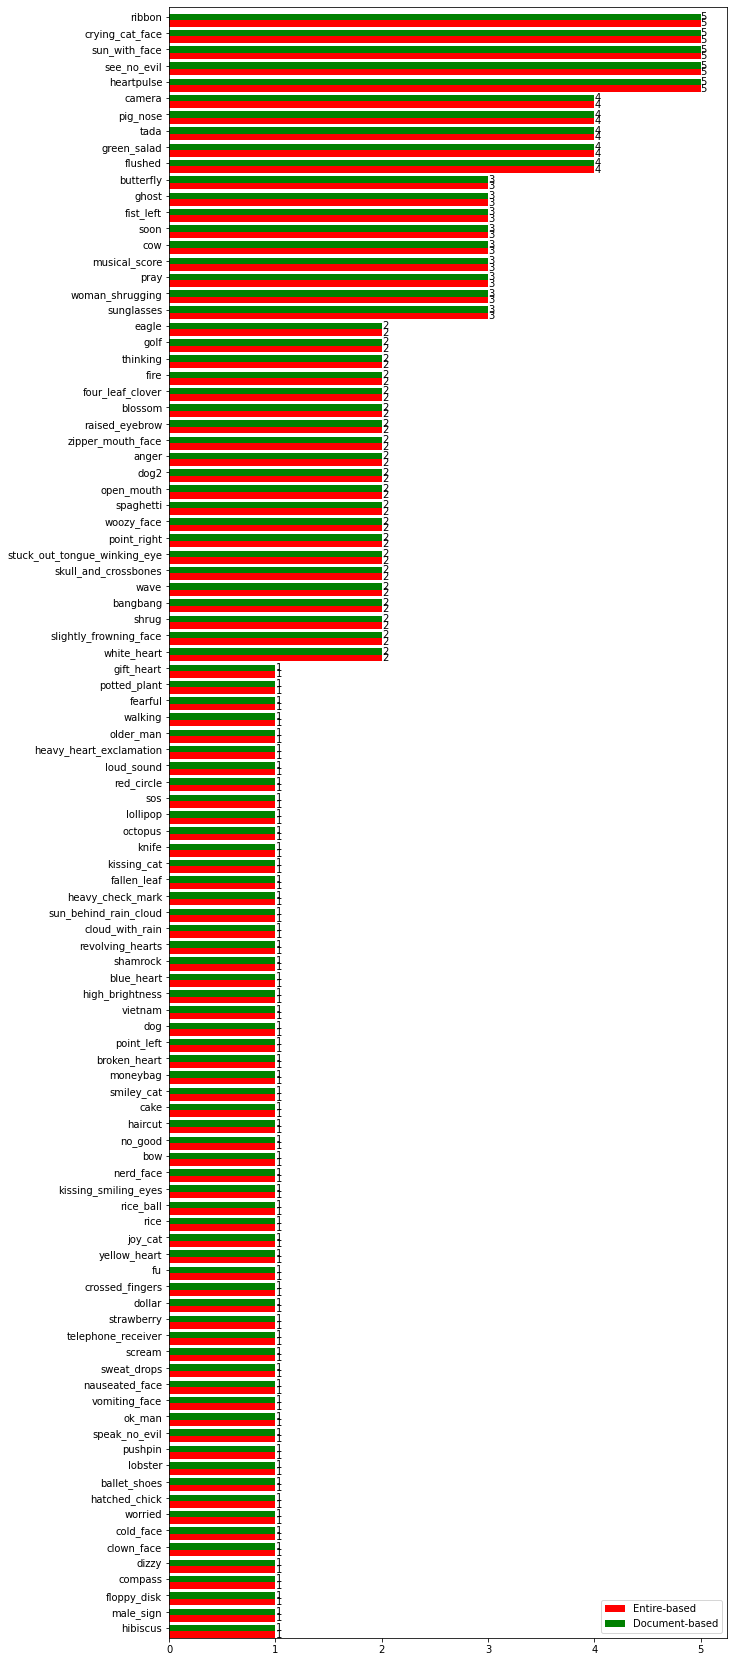

In [7]:
emoji_stat = Model.reviewStatistic(X_train['emoji_decode'], True)

Model.wordFrequencyBarplot(emoji_stat.head(100))

> **Nhận xét**:
> * Biểu đồ trên là 100 emoji có tần số xuất hiện thấp nhất trên toàn dataset emoji.
> * Ở đây, các thanh màu đỏ thể hiện tần suất của từ đó xuất hiện bao nhiêu lần trong dataset. Các thanh màu xanh thể hiện có bao nhiêu comment chứa emoji này.
> * Có thể thấy có nhiều emoji mà chỉ xuất hiện một lần. Như vậy ta có thể xem xét xây dựng các vectorizer với các ngưỡng `min_df` _(được nói chi tiết bên dưới)_ khác nhau để tìm xem đâu là vectorizer phù hợp nhất để làm input cho dataset emoji này.

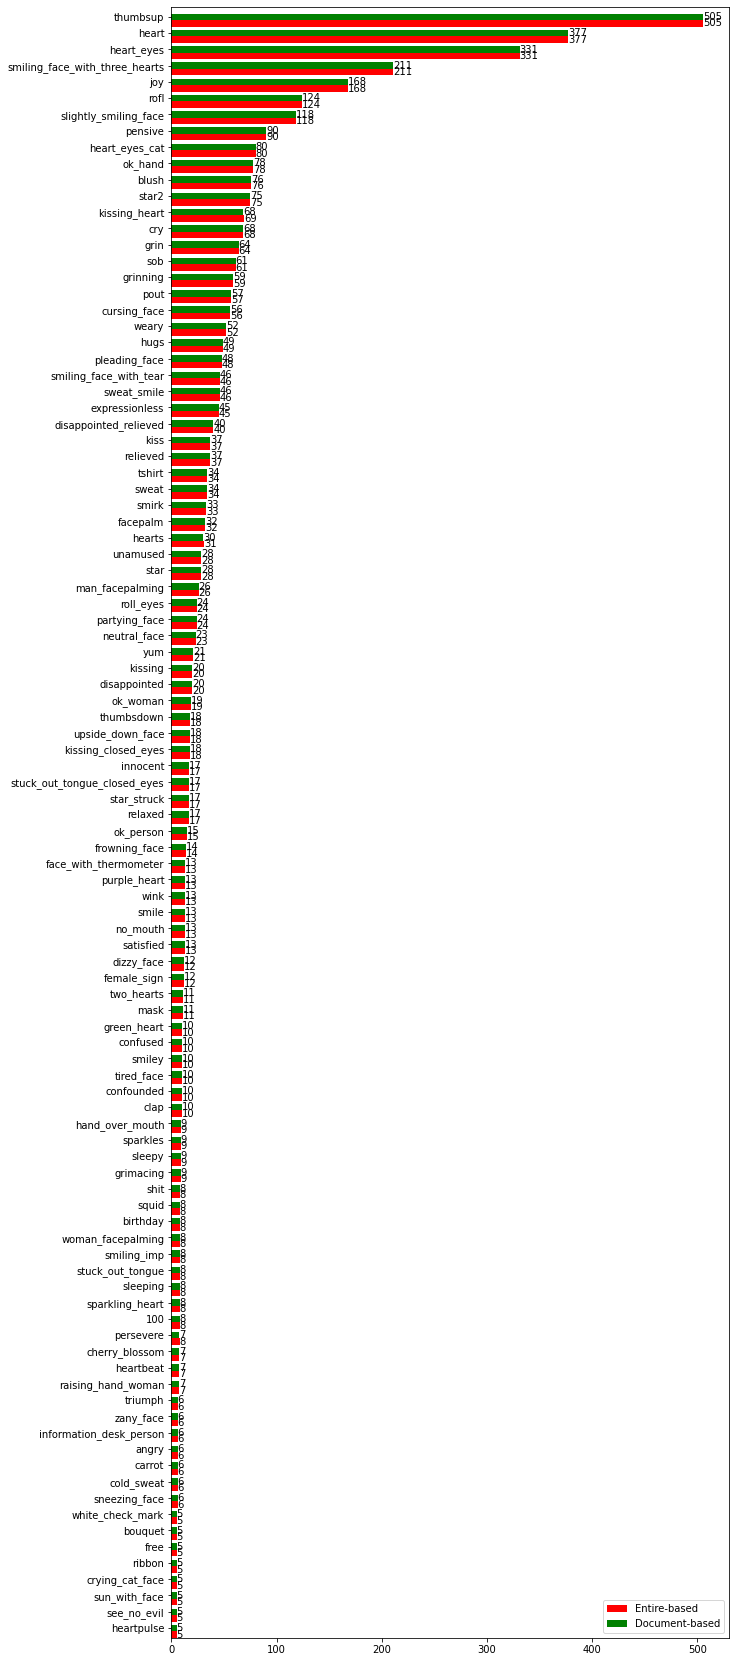

In [8]:
Model.wordFrequencyBarplot(emoji_stat.tail(100))

> **Nhận xét**:
> * Bên trên là 100 emoji có tần số xuất hiện nhiều nhất.
> * Từ hai biểu đồ trên, có thể tạo ra các vectorizer mà chúng chứa toàn bộ các emoji và các emoji có tần số xuất hiện $\geq 5$ lần.

Dưới đây, ta xây dựng bốn vectorizer theo các phương pháp **Bag of Words** và **TF-IDF**. Và lưu chúng vào một `list`.

Hai vectorizer đầu tiên, ta sử dụng toàn bộ các emoji trong dataset emoji.

Hai vectorizer cuối cùng, ta chỉ vectorize cho các emoji mà có tần số xuất hiện $\geq 5$ (`min_df=5`).

In [9]:
vectorizers = [
    ("Bag of Words", Model.vectorizer(X_train['emoji_decode'], 'bow')),
    ("TF-IDF", Model.vectorizer(X_train['emoji_decode'], 'tfidf')),
    ("Bag of Words - [min_df: 5]", Model.vectorizer(X_train['emoji_decode'], 'bow', 5)),
    ("TF-IDF - [min_df: 5]", Model.vectorizer(X_train['emoji_decode'], 'tfidf', 5))
]

Ta tiến hành kiểm tra vectorizer đầu tiên - Bag of Words trên toàn bộ dataset emoji.

In [10]:
print(vectorizers[0][1][0].get_feature_names())
pd.DataFrame(data=vectorizers[0][1][1].toarray(), columns=vectorizers[0][1][0].get_feature_names())

['100', 'anger', 'angry', 'ballet_shoes', 'bangbang', 'birthday', 'blossom', 'blue_heart', 'blush', 'bouquet', 'bow', 'broken_heart', 'butterfly', 'cake', 'camera', 'carrot', 'cherry_blossom', 'clap', 'cloud_with_rain', 'clown_face', 'cold_face', 'cold_sweat', 'compass', 'confounded', 'confused', 'cow', 'crossed_fingers', 'cry', 'crying_cat_face', 'cursing_face', 'disappointed', 'disappointed_relieved', 'dizzy', 'dizzy_face', 'dog', 'dog2', 'dollar', 'eagle', 'expressionless', 'face_with_thermometer', 'facepalm', 'fallen_leaf', 'fearful', 'female_sign', 'fire', 'fist_left', 'floppy_disk', 'flushed', 'four_leaf_clover', 'free', 'frowning_face', 'fu', 'ghost', 'gift_heart', 'golf', 'green_heart', 'green_salad', 'grimacing', 'grin', 'grinning', 'haircut', 'hand_over_mouth', 'hatched_chick', 'heart', 'heart_eyes', 'heart_eyes_cat', 'heartbeat', 'heartpulse', 'hearts', 'heavy_check_mark', 'heavy_heart_exclamation', 'hibiscus', 'high_brightness', 'hugs', 'information_desk_person', 'innocent'

,100,anger,angry,ballet_shoes,bangbang,birthday,blossom,blue_heart,blush,bouquet,...,white_heart,wink,woman_facepalming,woman_shrugging,woozy_face,worried,yellow_heart,yum,zany_face,zipper_mouth_face
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1023,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1024,0,0,0,0,0,0,0,0,11,0,...,0,0,0,0,0,0,0,0,0,0


> **Nhận xét**:
> * Ta có tổng cộng gần 200 emoji khác nhau trên hơn 1000 comment trong training dataset. Có thể thấy đây là một sparse-matrix.

In [11]:
pd.DataFrame(data=vectorizers[1][1][1].toarray(), columns=vectorizers[1][1][0].get_feature_names())

,100,anger,angry,ballet_shoes,bangbang,birthday,blossom,blue_heart,blush,bouquet,...,white_heart,wink,woman_facepalming,woman_shrugging,woozy_face,worried,yellow_heart,yum,zany_face,zipper_mouth_face
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.713115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> **Nhận xét**:
> * Phía trên ta kiểm tra vectorizer TF-IDF trên toàn bộ dataset emoji.

Vì dữ liệu của chúng ta khá nhỏ, ta có thể giữ lại toàn bộ vectorizer này để đào tạo model. Sau đó đánh giá để chọn ra vectorizer tốt nhất.

Tiếp theo, ta liệt kê một loạt các classification model, để chuẩn bị trước cho quá trình đào tạo.

Tiếp theo, ta sẽ áp dụng cross-validation, và ta muốn đảm bảo tính công bằng cho toàn bộ model nên ta sẽ tạo một đối tượng **StratifiedKFold**, như code bên dưới, nó chia training data thành 10 phần và giữ các thứ tự đó trong toàn bộ vòng đời của biến chứa nó.

In [12]:
lst_models = [
    ('Logistic Regression - [solver: lbfgs]', LogisticRegression(solver='lbfgs')),
    ('Logistic Regression - [solver: liblinear]', LogisticRegression(solver='liblinear')),
    ('Logistic Regression - [solver: newton-cg]', LogisticRegression(solver='newton-cg')),
    ('KNN - [n_neighbors: 2]', KNeighborsClassifier(n_neighbors=2)),
    ('KNN - [n_neighbors: 3]', KNeighborsClassifier(n_neighbors=3)),
    ('SVC - [kernel: linear]', SVC(kernel='linear', random_state=42)),
    ('SVC - [kernel: poly]', SVC(kernel='poly', random_state=42)),
    ('SVC - [kernel: rbf]', SVC(kernel='rbf', random_state=42)),
    ('SVC - [kernel: sigmoid]', SVC(kernel='sigmoid', random_state=42)),
    ('Bernoulli', BernoulliNB()),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(eval_metric='mlogloss'))
]

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Đào tạo toàn bộ các model trên.

In [13]:
original_models = Model.train(lst_models, vectorizers, y_train, cv)

original_models

Bag of Words:
	Model Logistic Regression - [solver: lbfgs] has been trained in 0.23 seconds
	Model Logistic Regression - [solver: liblinear] has been trained in 0.06 seconds
	Model Logistic Regression - [solver: newton-cg] has been trained in 0.28 seconds
	Model KNN - [n_neighbors: 2] has been trained in 0.50 seconds
	Model KNN - [n_neighbors: 3] has been trained in 0.51 seconds
	Model SVC - [kernel: linear] has been trained in 0.28 seconds
	Model SVC - [kernel: poly] has been trained in 0.42 seconds
	Model SVC - [kernel: rbf] has been trained in 0.45 seconds
	Model SVC - [kernel: sigmoid] has been trained in 0.36 seconds
	Model Bernoulli has been trained in 0.06 seconds
	Model Random Forest has been trained in 2.35 seconds
	Model XGBoost has been trained in 0.84 seconds
TF-IDF:
	Model Logistic Regression - [solver: lbfgs] has been trained in 0.15 seconds
	Model Logistic Regression - [solver: liblinear] has been trained in 0.06 seconds
	Model Logistic Regression - [solver: newton-cg] h

,vectorizer,model,train_acc,test_acc,diff_acc,train_acc_std,test_acc_std,train_roc_auc,test_roc_auc,diff_roc_auc,train_roc_auc_std,test_roc_auc_std,fit_time
0,TF-IDF,SVC - [kernel: rbf],0.893546,0.851875,0.041671,0.003487,0.038218,0.905123,0.873282,0.031841,0.016902,0.033987,0.011665
1,TF-IDF,Logistic Regression - [solver: liblinear],0.890189,0.850866,0.039322,0.004251,0.033072,0.930616,0.903272,0.027344,0.003066,0.036520,0.001485
2,TF-IDF,Logistic Regression - [solver: lbfgs],0.890189,0.850866,0.039322,0.004251,0.033072,0.930633,0.903188,0.027445,0.003078,0.036723,0.009695
3,TF-IDF,Logistic Regression - [solver: newton-cg],0.890189,0.850866,0.039322,0.004251,0.033072,0.930635,0.903188,0.027447,0.003078,0.036723,0.013808
4,TF-IDF,Random Forest,0.900802,0.847944,0.052858,0.003933,0.045535,0.957656,0.897262,0.060395,0.002273,0.035206,0.156891
5,TF-IDF,SVC - [kernel: poly],0.896578,0.847002,0.049576,0.003524,0.039243,0.905438,0.854690,0.050747,0.006277,0.044771,0.012058
6,Bag of Words,Bernoulli,0.882933,0.845012,0.037920,0.003072,0.034061,0.937264,0.898412,0.038853,0.002624,0.032872,0.001242
7,TF-IDF,Bernoulli,0.882933,0.845012,0.037920,0.003072,0.034061,0.937264,0.898412,0.038853,0.002624,0.032872,0.001526
8,TF-IDF,SVC - [kernel: sigmoid],0.881200,0.844080,0.037121,0.003237,0.037964,0.908762,0.881717,0.027045,0.010184,0.043808,0.010014
9,TF-IDF,SVC - [kernel: linear],0.887698,0.843118,0.044580,0.003094,0.036253,0.907317,0.871632,0.035685,0.010708,0.035922,0.008645


> **Nhận xét**:
> * Các thuật toán như SVM, Logistic Regression và Random Forest hoạt động khá tốt trên dữ liệu này.
> * Xem ra, các model này hoạt động tốt hơn trên vectorizer TF-IDF mà ta không lọc bớt các emoji. Tuy nhiên, ta khó có thể giải thích cho việc này. $\Rightarrow$ Ta sẽ dùng vectorizer này làm input cho toàn bộ các model về sau.
> * Accuracy `train/test_acc_acc` giữa training data và test data luôn đạt trên 85% ở 5 model đầu tiên, sự chênh lệch giữa train và test `diff_acc/roc_auc` thấp hơn 5%, ở ROC-AUC `train/test_roc_auc` cũng đạt trên 85%, chứng tỏ các emoji đang làm khá tốt vai trò của chúng để phân lớp và không có class nào nổi trội hơn class nào.
> * Nhìn vào phương sai `train/test_acc_std`, ta thấy được sự ổn định của model ở qua các cross-validation khác nhau. Tức không có một tập train-validation nào mà nó lại phù hợp quá mức với model.

In [14]:
Model.emojiEvaluationGroupedBarChart(original_models, 7)

> **Nhận xét**:
> * Biểu đồ trên thể hiện các độ đo `train_acc`, `test_acc`, `train_roc_auc` và `test_roc_auc` được sắp xếp giảm dần theo `test_acc`.
> * Nhìn vào đây, ta thấy sự khác biệt giữa các model là không quá lớn.

Bây giờ ta sẽ chọn ra một vài model mà nhóm cảm thấy là ổn nhất để tiến hành Tunning Hyperparameter bằng Grid-Search.

Ta sẽ thiết lập một vài hyperparams cho các model sau đó tiến hàng training lại trên cross-validation vừa rồi.

In [15]:
lst_tunning_models = [
    ('Logistic Regression - [solver: lbfgs]', LogisticRegression(solver='lbfgs'), {
        'C': [0.001, 0.01, 0.1, 1.0, 10, 100],
        'penalty': ['none', 'l1', 'l2', 'elasticnet']
        }),
    ('SVC - [kernel: rbf]', SVC(kernel='rbf', probability=True, random_state=42), {
        'gamma': [0.0001, 0.001, 0.01, 1.0, 10],
        'C': [0.1, 0.5, 1.0, 10, 25, 50, 75, 100]
        }),
    ('Random Forest', RandomForestClassifier(random_state=42), {
        'bootstrap': [False, True],
        'max_features': ["auto", "sqrt", "log2", 5, 10, 15, 20],
        'n_estimators': [100, 200, 300]
        })
]

Tiến hành train cross-validation và lựa ra các hyperparameter set cho từng model.

In [16]:
lst_tunning_models = Model.trainTunningModel(lst_tunning_models, vectorizers[1][1][1], y_train, cv)

lst_tunning_models

Model Logistic Regression - [solver: lbfgs] has been tunned in 2.55 seconds
Model SVC - [kernel: rbf] has been tunned in 23.04 seconds
Model Random Forest has been tunned in 140.28 seconds


[('Logistic Regression - [solver: lbfgs]', LogisticRegression()),
 ('SVC - [kernel: rbf]', SVC(gamma=1.0, probability=True, random_state=42)),
 ('Random Forest',
  RandomForestClassifier(bootstrap=False, max_features=5, random_state=42))]

Train lại từng model với hyperparameter set trả về trên toàn bộ training data (không chia valiadation nữa).

In [17]:
tunning_models = Model.train(lst_tunning_models, [vectorizers[1]], y_train, cv)

TF-IDF:
	Model Logistic Regression - [solver: lbfgs] has been trained in 0.16 seconds
	Model SVC - [kernel: rbf] has been trained in 0.72 seconds
	Model Random Forest has been trained in 2.32 seconds


In [18]:
tunning_models

,vectorizer,model,train_acc,test_acc,diff_acc,train_acc_std,test_acc_std,train_roc_auc,test_roc_auc,diff_roc_auc,train_roc_auc_std,test_roc_auc_std,fit_time
0,TF-IDF,SVC - [kernel: rbf],0.893546,0.851875,0.041671,0.003487,0.038218,0.908397,0.866576,0.041821,0.006690,0.036262,0.049807
1,TF-IDF,Logistic Regression - [solver: lbfgs],0.890189,0.850866,0.039322,0.004251,0.033072,0.930633,0.903188,0.027445,0.003078,0.036723,0.010267
2,TF-IDF,Random Forest,0.900802,0.850857,0.049945,0.003933,0.045930,0.963234,0.891460,0.071774,0.002116,0.036349,0.161276


> **Nhận xét**:
> * SVC vẫn là model tốt nhất với bộ tham số mặc định với kernel `rbf`. Tuy nhiên sự khác biệt giữa các model là không quá lớn trên `test_acc`, chỉ hơn thua nhau 1%.

Load dữ liệu test lên để đánh giá và vẫn chọn vectorizer TF-IDF đại diện cho toàn bộ dataset emoji.

In [19]:
X_test, y_test = Model.loadData("./data/emoji_data/test")

In [20]:
tfidf_test_emojis = vectorizers[1][1][0].transform(X_test['emoji_decode'])
best_models = Model.evaluation(lst_tunning_models, vectorizers[1][1][1], y_train, tfidf_test_emojis, y_test)

best_models

,model,train_acc,test_acc,train_roc_auc,test_roc_auc
0,Logistic Regression - [solver: lbfgs],0.887914,0.824903,0.865063,0.790367
1,SVC - [kernel: rbf],0.891813,0.821012,0.869359,0.791302
2,Random Forest,0.899610,0.793774,0.889707,0.771456


> **Nhận xét**:
> * Hai model Logistic và SVC có hiệu suất có thể chấp nhận được khi độ lệch giữa `train_acc` và `test_acc` dưới 10%.
> * Tuy nhiên, lúc này ta có thể thấy test data của ta có sự nổi trội hơn của một trong hai class positive và negative so với class còn lại dựa vào `test_roc_auc`. Điều này có thể do hai lí do, test data của ta thực sự bị lệch hoặc model của ta bị overfitting, nhưng khả năng cao là test data bị lệch vì `test_roc_auc` có hiệu suất vẫn chấp nhận được.
> * Random Forest lúc này bị overfitting, chênh lệch giữa `train_acc` và `test_acc` đã chạm ngưỡng 10%.

Tiến hành kiểm tra các hyper-params sau khi tunning trên 3 model trên.

In [21]:
lst_tunning_models

[('Logistic Regression - [solver: lbfgs]', LogisticRegression()),
 ('SVC - [kernel: rbf]', SVC(gamma=1.0, probability=True, random_state=42)),
 ('Random Forest',
  RandomForestClassifier(bootstrap=False, max_features=5, random_state=42))]

> **Nhận xét**:
> * Ở đây, chỉ có hai model là Random Forest và SVC là có hyper-params thay đổi sau quá trình tunning.
> * Model Logistic vẫn giữ nguyên các hyper-params mặc định của sklearn.

Bây giờ, ta sẽ lưu các model bên trên lại cùng với vectorizer vào cùng một object do ta định nghĩa là `SentimentModel`. Mục đích của chúng ta là để cho ta dễ dàng tái sử dụng chúng về sau và cũng như lưu trữ thành cùng một file `*.pickle` duy nhất.

In [22]:
logistic_model = Model.SentimentModel(lst_tunning_models[0][1], vectorizers[1], y_train)
svc_model = Model.SentimentModel(lst_tunning_models[1][1], vectorizers[1], y_train)
rdforest_model = Model.SentimentModel(lst_tunning_models[2][1], vectorizers[1], y_train)

print(logistic_model.info())
print(svc_model.info())
print(rdforest_model.info())

LogisticRegression()
None
SVC(gamma=1.0, probability=True, random_state=42)
None
RandomForestClassifier(bootstrap=False, max_features=5, random_state=42)
None


Ở phần này, ta tiến hành đánh giá và trực quan kết quả đánh giá trên toàn bộ training data và test data bằng hai độ đo là accuracy và ROC-AUC. 

              precision    recall  f1-score   support

    Negative       0.88      0.79      0.83       357
    Positive       0.89      0.94      0.92       669

    accuracy                           0.89      1026
   macro avg       0.88      0.87      0.87      1026
weighted avg       0.89      0.89      0.89      1026



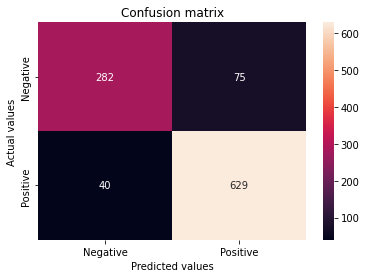

              precision    recall  f1-score   support

    Negative       0.85      0.65      0.74        97
    Positive       0.81      0.93      0.87       160

    accuracy                           0.82       257
   macro avg       0.83      0.79      0.80       257
weighted avg       0.83      0.82      0.82       257



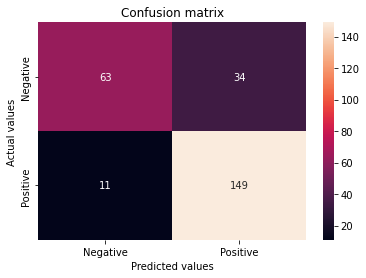

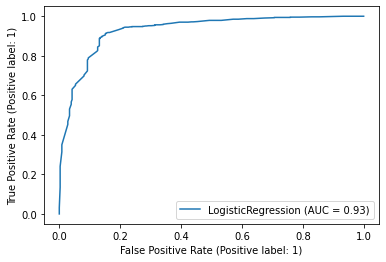

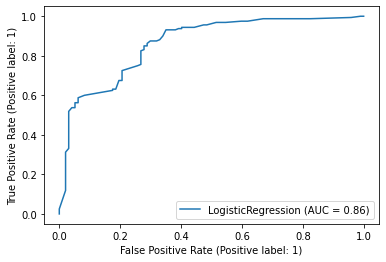

,input,output_proba,output_class
0,heart_eyes,"(0.0690459925648299, 0.9309540074351701)",1
1,hearts hearts hearts kissing_heart kissing_hea...,"(0.0639276610567524, 0.9360723389432476)",1
2,relieved,"(0.7222422050450168, 0.2777577949549832)",0
3,sob sob sob persevere persevere persevere pers...,"(0.6086211652496625, 0.39137883475033747)",0
4,heart heart,"(0.03977199088274086, 0.9602280091172591)",1
...,...,...,...
1021,gift_heart,"(0.3500220073124234, 0.6499779926875766)",1
1022,heart,"(0.03977199088274086, 0.9602280091172591)",1
1023,hugs wink,"(0.3321253514338075, 0.6678746485661925)",1
1024,blush blush blush blush blush blush blush blus...,"(0.13724536542157273, 0.8627546345784273)",1


,input,output_proba,output_class
0,wink,"(0.3712072811835553, 0.6287927188164447)",1
1,heart,"(0.03977199088274086, 0.9602280091172591)",1
2,rofl rofl,"(0.3070906240706651, 0.6929093759293349)",1
3,rofl rofl rofl rofl rofl rofl rofl rofl rofl r...,"(0.1682098403308303, 0.8317901596691697)",1
4,heart_eyes heart_eyes,"(0.0690459925648299, 0.9309540074351701)",1
...,...,...,...
252,shit,"(0.5461358590363463, 0.4538641409636537)",0
253,joy,"(0.2386855657399103, 0.7613144342600897)",1
254,disappointed disappointed disappointed disappo...,"(0.7608262221340357, 0.23917377786596428)",0
255,cry,"(0.6713100653363226, 0.3286899346636773)",0


In [23]:
# Logistic model
y_train_pred = logistic_model.predict(X_train['emoji_decode'])
y_test_pred = logistic_model.predict(X_test['emoji_decode'])

Model.confusionMatrix(y_train, y_train_pred['output_class'])
Model.confusionMatrix(y_test, y_test_pred['output_class'])

logistic_model.rocAuc(X_train['emoji_decode'], y_train)
logistic_model.rocAuc(X_test['emoji_decode'], y_test)

display(y_train_pred, y_test_pred)

              precision    recall  f1-score   support

    Negative       0.88      0.80      0.84       357
    Positive       0.90      0.94      0.92       669

    accuracy                           0.89      1026
   macro avg       0.89      0.87      0.88      1026
weighted avg       0.89      0.89      0.89      1026



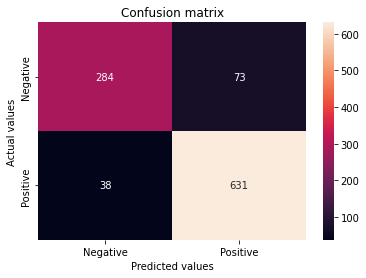

              precision    recall  f1-score   support

    Negative       0.82      0.67      0.74        97
    Positive       0.82      0.91      0.86       160

    accuracy                           0.82       257
   macro avg       0.82      0.79      0.80       257
weighted avg       0.82      0.82      0.82       257



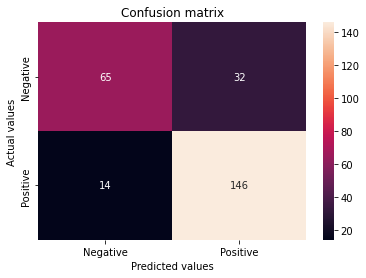

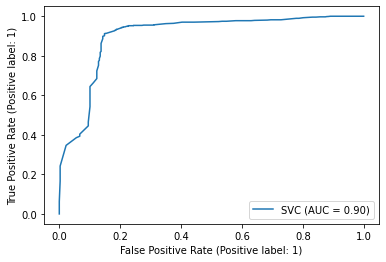

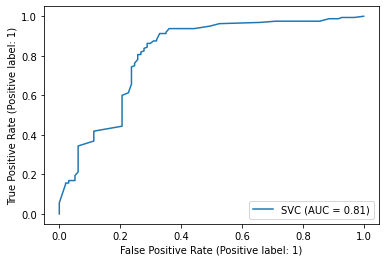

,input,output_proba,output_class
0,heart_eyes,"(0.10266231365321639, 0.8973376863467836)",1
1,hearts hearts hearts kissing_heart kissing_hea...,"(0.10232899031493847, 0.8976710096850615)",1
2,relieved,"(0.867374421854991, 0.13262557814500886)",0
3,sob sob sob persevere persevere persevere pers...,"(0.7574393894608992, 0.24256061053910113)",0
4,heart heart,"(0.09273168262614771, 0.9072683173738522)",1
...,...,...,...
1021,gift_heart,"(0.10270967458866774, 0.8972903254113321)",1
1022,heart,"(0.09273168262614771, 0.9072683173738522)",1
1023,hugs wink,"(0.10272172235742406, 0.897278277642576)",1
1024,blush blush blush blush blush blush blush blus...,"(0.10269418172196916, 0.8973058182780309)",1


,input,output_proba,output_class
0,wink,"(0.14995291012493978, 0.8500470898750603)",1
1,heart,"(0.09273168262614771, 0.9072683173738522)",1
2,rofl rofl,"(0.10263782191175236, 0.8973621780882477)",1
3,rofl rofl rofl rofl rofl rofl rofl rofl rofl r...,"(0.09508878763041478, 0.9049112123695854)",1
4,heart_eyes heart_eyes,"(0.10266231365321639, 0.8973376863467836)",1
...,...,...,...
252,shit,"(0.7657189508922359, 0.23428104910776407)",0
253,joy,"(0.10265509139923557, 0.8973449086007645)",1
254,disappointed disappointed disappointed disappo...,"(0.8672722047277136, 0.13272779527228637)",0
255,cry,"(0.8674118652597433, 0.13258813474025677)",0


In [24]:
y_train_pred = svc_model.predict(X_train['emoji_decode'])
y_test_pred = svc_model.predict(X_test['emoji_decode'])

Model.confusionMatrix(y_train, y_train_pred['output_class'])
Model.confusionMatrix(y_test, y_test_pred['output_class'])

svc_model.rocAuc(X_train['emoji_decode'], y_train)
svc_model.rocAuc(X_test['emoji_decode'], y_test)

display(y_train_pred, y_test_pred)

              precision    recall  f1-score   support

    Negative       0.85      0.86      0.86       357
    Positive       0.92      0.92      0.92       669

    accuracy                           0.90      1026
   macro avg       0.89      0.89      0.89      1026
weighted avg       0.90      0.90      0.90      1026



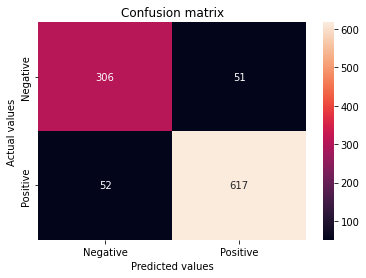

              precision    recall  f1-score   support

    Negative       0.75      0.68      0.71        97
    Positive       0.82      0.86      0.84       160

    accuracy                           0.79       257
   macro avg       0.78      0.77      0.78       257
weighted avg       0.79      0.79      0.79       257



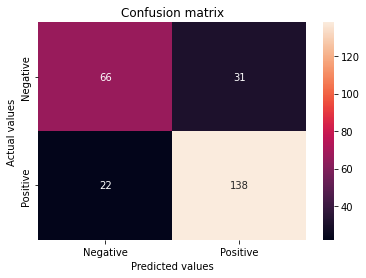

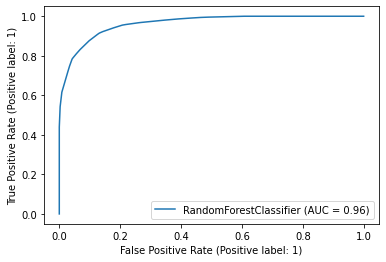

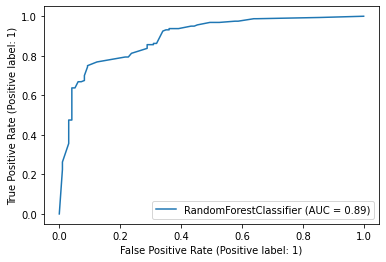

,input,output_proba,output_class
0,heart_eyes,"(0.03921568627450975, 0.9607843137254879)",1
1,hearts hearts hearts kissing_heart kissing_hea...,"(0.0, 1.0)",1
2,relieved,"(0.833333333333333, 0.16666666666666646)",0
3,sob sob sob persevere persevere persevere pers...,"(0.0, 1.0)",1
4,heart heart,"(0.014285714285714256, 0.9857142857142847)",1
...,...,...,...
1021,gift_heart,"(0.0, 1.0)",1
1022,heart,"(0.014285714285714256, 0.9857142857142847)",1
1023,hugs wink,"(0.0, 1.0)",1
1024,blush blush blush blush blush blush blush blus...,"(0.09523809523809508, 0.904761904761903)",1


,input,output_proba,output_class
0,wink,"(0.5, 0.5)",0
1,heart,"(0.014285714285714256, 0.9857142857142847)",1
2,rofl rofl,"(0.3125, 0.6875)",1
3,rofl rofl rofl rofl rofl rofl rofl rofl rofl r...,"(0.04983552631578947, 0.9501644736842105)",1
4,heart_eyes heart_eyes,"(0.03921568627450975, 0.9607843137254879)",1
...,...,...,...
252,shit,"(1.0, 0.0)",0
253,joy,"(0.2631578947368424, 0.7368421052631585)",1
254,disappointed disappointed disappointed disappo...,"(0.9000000000000008, 0.09999999999999981)",0
255,cry,"(0.7777777777777771, 0.22222222222222177)",0


In [25]:
y_train_pred = rdforest_model.predict(X_train['emoji_decode'])
y_test_pred = rdforest_model.predict(X_test['emoji_decode'])

Model.confusionMatrix(y_train, y_train_pred['output_class'])
Model.confusionMatrix(y_test, y_test_pred['output_class'])

rdforest_model.rocAuc(X_train['emoji_decode'], y_train)
rdforest_model.rocAuc(X_test['emoji_decode'], y_test)

display(y_train_pred, y_test_pred)

> **Nhận xét**:
> * Model Random forest bị hiện tượng overfitting, hai model còn lại có xu hướng nhận diện sai các mẫu theo đúng là negative nhưng lại nhầm sang positive.
> * Tuy nhiên, nhìn chung thì hai model logistic và svm vẫn tốt, accuracy trên 80% - đây cũng là một con số khá ổn cho một tập dữ liệu dạng text như vầy.
> * Tiếp theo, nhờ vào trực quan ta cũng lí giải được lí do vì sao ROC-AUC lại thấp vì số true negative sample là khoảng 100 trong khi ở true positive sample là 150.

Ta tiến hành lưu các model này lại kèm theo vectorizer TF-IDF dưới dạng file `*.pickle`.

Nhìn chung, ta thấy model Logistic hoạt động tốt nhất, tuy nhiên ta chưa biết liệu khi kết hợp với **Comment sentiment model** thì hiệu quả kết hợp giữa chúng sẽ như thế nào, nên ta sẽ lưu toàn bộ lại.

In [26]:
Model.saveByPickle(svc_model, "./models/svc_model_emojis.pickle")
Model.saveByPickle(logistic_model, "./models/logistic_model_emojis.pickle")
Model.saveByPickle(rdforest_model, "./models/rdforest_model_emojis.pickle")

<modules.model.SentimentModel object at 0x7ff6cd8adac0> has been saved at ./models/svc_model_emojis.pickle.
<modules.model.SentimentModel object at 0x7ff6cd8adbb0> has been saved at ./models/logistic_model_emojis.pickle.
<modules.model.SentimentModel object at 0x7ff7a53d8940> has been saved at ./models/rdforest_model_emojis.pickle.
